In [1]:
import numpy as np
import matplotlib.pyplot as plt

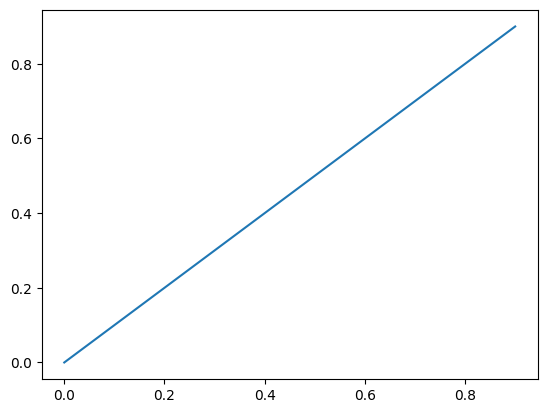

In [2]:
plt.plot(np.arange(0, 1, 0.1), np.arange(0, 1, 0.1))

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim


In [4]:
from scipy import stats
import time

In [5]:
epochs = 200
rTrain = 0.7;
rTest = 0.2;
# input_vector_length = 100
batch_size = 32
num_bins = 40
coef_delta = 0

In [232]:
# epochs = 400
# test_sample_ratio = .2
# validation_sample_ratio = 0.1
# batch_size = 32
# coef_delta = 0

# noise_ratio = 0.9
# bbh_ratio = 0.1


## Data preparation

In [6]:
renorm_factor = 20;

realbkg = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/background.npz")['data'] / renorm_factor;
realbbh = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy") / renorm_factor;

realsg = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy") / renorm_factor;

In [7]:
realglitch = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"] / 12.3

We only care about pattern, so we center each input to 0 by subtracting its mean, and renormalize by dividing over $\sigma$

In [8]:
realbkg_trimmed = realbkg[:, 0];
realbbh_trimmed = realbbh[:, 0];
realsg_trimmed  = realsg[:, 0];

realbkg_trimmed = (realbkg_trimmed - np.transpose([np.mean(realbkg_trimmed, axis=1)]))/np.transpose([np.std(realbkg_trimmed, axis=1)]);
realbbh_trimmed = (realbbh_trimmed - np.transpose([np.mean(realbbh_trimmed, axis=1)]))/np.transpose([np.std(realbbh_trimmed, axis=1)]);
realsg_trimmed  = (realsg_trimmed  - np.transpose([np.mean(realsg_trimmed , axis=1)]))/np.transpose([np.std(realsg_trimmed,  axis=1)]);

In [9]:
realglitch_trimmed = (realglitch - np.transpose([np.mean(realglitch, axis=1)]))/np.transpose([np.std(realglitch, axis=1)])

In [10]:
dInput = realbkg_trimmed.shape[1]

In [17]:
# nTotal = len(bkg);
nTotal = len(realbbh_trimmed);
nTrain = int(rTrain * nTotal)
nTest  = int(rTest * nTotal)
nValid = nTotal - nTrain - nTest;

nTrain_g = int(rTrain * len(realglitch_trimmed))
nTest_g  = int(rTest  * len(realglitch_trimmed))
nValid_g = len(realglitch_trimmed) - nTrain_g - nTest_g;

X_train = np.empty((3*nTrain + nTrain_g, dInput))
X_test  = np.empty((3*nTest + nTest_g,  dInput))
X_valid = np.empty((3*nValid + nValid_g, dInput))

target_train = np.zeros((3*nTrain + nTrain_g,), dtype="int64")
target_test  = np.zeros((3*nTest + nTest_g, ), dtype="int64")
target_valid = np.zeros((3*nValid + nValid_g,), dtype="int64")

permBKG = np.random.permutation(nTotal)
permBBH = np.random.permutation(nTotal)
permSG  = np.random.permutation(nTotal)
permGLITCH = np.random.permutation(len(realglitch_trimmed))

np.savetxt("../Data_cached/SupLearn/perm_BKG.dat", permBKG)
np.savetxt("../Data_cached/SupLearn/perm_BBH.dat", permBBH)
np.savetxt("../Data_cached/SupLearn/perm_SG.dat", permSG)
np.savetxt("../Data_cached/SupLearn/perm_GLITCH.dat", permGLITCH)

# initializing the training set
X_train[:nTrain] = realbkg_trimmed[permBKG[:nTrain]]
X_train[nTrain:2*nTrain] = realbbh_trimmed[permBBH[:nTrain]]
X_train[2*nTrain:3*nTrain] = realsg_trimmed[permSG[:nTrain]]
X_train[3*nTrain:] = realglitch_trimmed[permGLITCH[:nTrain_g]]

target_train[:nTrain] = 1;
target_train[nTrain:2*nTrain] = 2;
target_train[2*nTrain:3*nTrain] = 3;

# initializing the test set
X_test[:nTest] = realbkg_trimmed[permBKG[-nTest:]]
X_test[nTest:2*nTest] = realbbh_trimmed[permBBH[-nTest:]]
X_test[2*nTest:3*nTest] = realsg_trimmed[permSG[-nTest:]]
X_test[3*nTest:] = realglitch_trimmed[permGLITCH[-nTest_g:]]

target_test[:nTest] = 1;
target_test[nTest:2*nTest] = 2;
target_test[2*nTest:3*nTest] = 3;

# initializing the validation set
X_valid[:nValid] = realbkg_trimmed[permBKG[nTrain:-nTest]]
X_valid[nValid:2*nValid] = realbbh_trimmed[permBBH[nTrain:-nTest]]
X_valid[2*nValid:3*nValid] = realsg_trimmed[permSG[nTrain:-nTest]]
X_valid[3*nValid:] = realglitch_trimmed[permGLITCH[nTrain_g:-nTest_g]]

target_valid[:nValid] = 1;
target_valid[nValid:2*nValid] = 2;
target_valid[2*nValid:3*nValid] = 3;

train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.tensor(target_train))
test_dataset  = TensorDataset(torch.FloatTensor(X_test),  torch.tensor(target_test))
valid_dataset = TensorDataset(torch.FloatTensor(X_valid), torch.tensor(target_valid))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

# X_train = realbbh_trimmed[perm[:nTrain]]
# X_test = realbbh_trimmed[perm[-nTest:]]
# X_validation = realbbh_trimmed[perm[nTrain:-nTest]]

# trainData = torch.FloatTensor(X_train)
# testData = torch.FloatTensor(X_test)
# validationData = torch.FloatTensor(X_validation)

# train_dataset = TensorDataset(trainData, trainData)
# test_dataset = TensorDataset(testData, testData)
# validation_dataset = TensorDataset(validationData, validationData)

# trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

In [18]:
# nTotal = len(bkg);
nTotal = len(realbbh_trimmed);
nTrain = int(rTrain * nTotal)
nTest  = int(rTest * nTotal)
nValid = nTotal - nTrain - nTest;

nTrain_g = int(rTrain * len(realglitch_trimmed))
nTest_g  = int(rTest  * len(realglitch_trimmed))
nValid_g = len(realglitch_trimmed) - nTrain_g - nTest_g;

X_train = np.empty((2*nTrain + nTrain_g, dInput))
X_test  = np.empty((3*nTest + nTest_g,  dInput))
X_valid = np.empty((2*nValid + nValid_g, dInput))

target_train = np.zeros((2*nTrain + nTrain_g,), dtype="int64")
target_test  = np.zeros((3*nTest + nTest_g, ), dtype="int64")
target_valid = np.zeros((2*nValid + nValid_g,), dtype="int64")

# permBKG = np.random.permutation(nTotal)
# permBBH = np.random.permutation(nTotal)
# permSG  = np.random.permutation(nTotal)
# permGLITCH = np.random.permutation(len(realglitch_trimmed))

# np.savetxt("../Data_cached/SupLearn/perm_BKG.dat", permBKG)
# np.savetxt("../Data_cached/SupLearn/perm_BBH.dat", permBBH)
# np.savetxt("../Data_cached/SupLearn/perm_SG.dat", permSG)
# np.savetxt("../Data_cached/SupLearn/perm_GLITCH.dat", permGLITCH)

permBKG = np.genfromtxt("../Data_cached/SupLearn/perm_BKG.dat").astype(int)
permBBH = np.genfromtxt("../Data_cached/SupLearn/perm_BBH.dat").astype(int)
permSG = np.genfromtxt("../Data_cached/SupLearn/perm_SG.dat").astype(int)
permGLITCH = np.genfromtxt("../Data_cached/SupLearn/perm_GLITCH.dat").astype(int)


# initializing the training set
X_train[:nTrain] = realbkg_trimmed[permBKG[:nTrain]]
X_train[nTrain:2*nTrain] = realbbh_trimmed[permBBH[:nTrain]]
# X_train[2*nTrain:3*nTrain] = realsg_trimmed[permSG[:nTrain]]
X_train[2*nTrain:] = realglitch_trimmed[permGLITCH[:nTrain_g]]

target_train[:nTrain] = 1;
target_train[nTrain:2*nTrain] = 2;
# target_train[2*nTrain:] = 3;

# initializing the test set
X_test[:nTest] = realbkg_trimmed[permBKG[-nTest:]]
X_test[nTest:2*nTest] = realbbh_trimmed[permBBH[-nTest:]]
X_test[2*nTest:3*nTest] = realsg_trimmed[permSG[-nTest:]]
X_test[3*nTest:] = realglitch_trimmed[permGLITCH[-nTest_g:]]

target_test[:nTest] = 1;
target_test[nTest:2*nTest] = 2;
target_test[2*nTest:3*nTest] = 3;

# initializing the validation set
X_valid[:nValid] = realbkg_trimmed[permBKG[nTrain:-nTest]]
X_valid[nValid:2*nValid] = realbbh_trimmed[permBBH[nTrain:-nTest]]
# X_valid[2*nValid:3*nValid] = realsg_trimmed[permSG[nTrain:-nTest]]
X_valid[2*nValid:] = realglitch_trimmed[permGLITCH[nTrain_g:-nTest_g]]

target_valid[:nValid] = 1;
target_valid[nValid:2*nValid] = 2;
# target_valid[2*nValid:] = 3;

train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.tensor(target_train))
test_dataset  = TensorDataset(torch.FloatTensor(X_test),  torch.tensor(target_test))
valid_dataset = TensorDataset(torch.FloatTensor(X_valid), torch.tensor(target_valid))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

# X_train = realbbh_trimmed[perm[:nTrain]]
# X_test = realbbh_trimmed[perm[-nTest:]]
# X_validation = realbbh_trimmed[perm[nTrain:-nTest]]

# trainData = torch.FloatTensor(X_train)
# testData = torch.FloatTensor(X_test)
# validationData = torch.FloatTensor(X_validation)

# train_dataset = TensorDataset(trainData, trainData)
# test_dataset = TensorDataset(testData, testData)
# validation_dataset = TensorDataset(validationData, validationData)

# trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

## Train the model

### 200-256-64-16-4 overfits

In [67]:
class SLDNN(nn.Module):
    def __init__(self):
        super(SLDNN, self).__init__()
        self.fc1 = nn.Linear(200, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 16)
        self.output = nn.Linear(16, 4)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        
        # CrossEntropyLoss apply softmax automatically
        return self.output(x)
    
#         x = self.sig(self.fc3(x))
#         return x

In [124]:
classifier = SLDNN().cuda()

print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.CrossEntropyLoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x.cuda()
        tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x.cuda()
            tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_valid)))
    print(time.time() - t0)

#     print(time.time() - t0)
torch.save(classifier.cuda(), "../data/SupLearn/Classifier.pt")
np.savetxt("../data/SupLearn/lossClassifierTraining.dat", [loss_train, loss_validation])

69012
Epoch: 0001, Training loss=0.716341, Validation loss=0.659474, valid accuracy=0.727525
22.961671829223633
Epoch: 0002, Training loss=0.724929, Validation loss=0.591136, valid accuracy=0.760685
24.01495623588562
Epoch: 0003, Training loss=1.565517, Validation loss=0.538217, valid accuracy=0.780491
20.58991241455078
Epoch: 0004, Training loss=0.755785, Validation loss=0.484133, valid accuracy=0.801039
22.432342529296875
Epoch: 0005, Training loss=0.428920, Validation loss=0.453784, valid accuracy=0.817716
21.063053607940674
Epoch: 0006, Training loss=0.681117, Validation loss=0.429937, valid accuracy=0.828425
22.68608546257019
Epoch: 0007, Training loss=0.755017, Validation loss=0.410904, valid accuracy=0.837521
20.667065382003784
Epoch: 0008, Training loss=0.558902, Validation loss=0.389444, valid accuracy=0.846650
19.968596696853638
Epoch: 0009, Training loss=0.081652, Validation loss=0.375257, valid accuracy=0.854005
22.784510612487793
Epoch: 0010, Training loss=0.174944, Valida

Epoch: 0079, Training loss=0.026585, Validation loss=0.566696, valid accuracy=0.875714
20.04725408554077
Epoch: 0080, Training loss=0.146381, Validation loss=0.562812, valid accuracy=0.877327
19.778343439102173
Epoch: 0081, Training loss=0.020258, Validation loss=0.582236, valid accuracy=0.876456
22.07459568977356
Epoch: 0082, Training loss=0.305928, Validation loss=0.583661, valid accuracy=0.876294
21.450264930725098
Epoch: 0083, Training loss=0.002741, Validation loss=0.581180, valid accuracy=0.877327
19.689656496047974
Epoch: 0084, Training loss=0.001639, Validation loss=0.585805, valid accuracy=0.876004
18.82499384880066
Epoch: 0085, Training loss=0.079334, Validation loss=0.585941, valid accuracy=0.877617
23.100166082382202
Epoch: 0086, Training loss=0.645020, Validation loss=0.590487, valid accuracy=0.875746
29.53008484840393
Epoch: 0087, Training loss=0.000625, Validation loss=0.600735, valid accuracy=0.878262
26.67200207710266
Epoch: 0088, Training loss=0.001660, Validation los

Epoch: 0157, Training loss=0.014810, Validation loss=1.042145, valid accuracy=0.872004
23.1200213432312
Epoch: 0158, Training loss=0.004427, Validation loss=1.054458, valid accuracy=0.871649
23.16968321800232
Epoch: 0159, Training loss=0.011135, Validation loss=1.056529, valid accuracy=0.870617
24.980197191238403
Epoch: 0160, Training loss=0.000028, Validation loss=1.074001, valid accuracy=0.870617
24.484914779663086
Epoch: 0161, Training loss=0.002936, Validation loss=1.059109, valid accuracy=0.873069
24.940213441848755
Epoch: 0162, Training loss=0.072237, Validation loss=1.086755, valid accuracy=0.872811
25.069716691970825
Epoch: 0163, Training loss=0.052214, Validation loss=1.097361, valid accuracy=0.870101
22.898345708847046
Epoch: 0164, Training loss=0.042114, Validation loss=1.092121, valid accuracy=0.872004
21.464560747146606
Epoch: 0165, Training loss=0.001882, Validation loss=1.095971, valid accuracy=0.872004
23.666841983795166
Epoch: 0166, Training loss=0.012193, Validation l

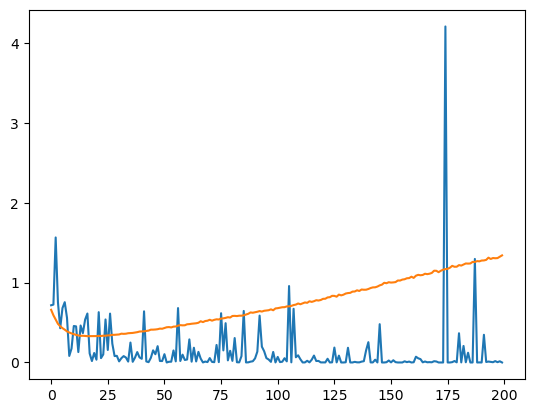

In [125]:
plt.plot(loss_train)
plt.plot(loss_validation)

### 200-128-64-16-4: better but still overfits

In [127]:
class SLDNN(nn.Module):
    def __init__(self):
        super(SLDNN, self).__init__()
        self.fc1 = nn.Linear(200, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.output = nn.Linear(16, 4)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        
        # CrossEntropyLoss apply softmax automatically
        return self.output(x)
    
#         x = self.sig(self.fc3(x))
#         return x

In [128]:
classifier = SLDNN().cuda()

print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.CrossEntropyLoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x.cuda()
        tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x.cuda()
            tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_valid)))
    print(time.time() - t0)

#     print(time.time() - t0)
torch.save(classifier.cuda(), "../data/SupLearn/Classifier.pt")
np.savetxt("../data/SupLearn/lossClassifierTraining.dat", [loss_train, loss_validation])

35092
Epoch: 0001, Training loss=0.395813, Validation loss=0.718931, valid accuracy=0.682817
21.692484617233276
Epoch: 0002, Training loss=0.712611, Validation loss=0.648337, valid accuracy=0.726235
21.730019569396973
Epoch: 0003, Training loss=0.354911, Validation loss=0.601300, valid accuracy=0.751847
20.64396905899048
Epoch: 0004, Training loss=0.942349, Validation loss=0.558352, valid accuracy=0.766943
19.985103845596313
Epoch: 0005, Training loss=0.688014, Validation loss=0.514905, valid accuracy=0.787329
20.99190378189087
Epoch: 0006, Training loss=0.159022, Validation loss=0.488268, valid accuracy=0.798974
25.618062734603882
Epoch: 0007, Training loss=0.238200, Validation loss=0.473634, valid accuracy=0.804587
23.176112413406372
Epoch: 0008, Training loss=0.627101, Validation loss=0.463786, valid accuracy=0.810135
20.043574571609497
Epoch: 0009, Training loss=0.098818, Validation loss=0.453601, valid accuracy=0.815329
19.42044949531555
Epoch: 0010, Training loss=0.667101, Valida

Epoch: 0079, Training loss=0.076727, Validation loss=0.342375, valid accuracy=0.889649
23.556243181228638
Epoch: 0080, Training loss=0.040766, Validation loss=0.338582, valid accuracy=0.890487
21.225228786468506
Epoch: 0081, Training loss=0.007333, Validation loss=0.339197, valid accuracy=0.890326
20.81974196434021
Epoch: 0082, Training loss=0.117956, Validation loss=0.339865, valid accuracy=0.890165
20.362417221069336
Epoch: 0083, Training loss=0.037585, Validation loss=0.341204, valid accuracy=0.889971
19.284769773483276
Epoch: 0084, Training loss=0.024398, Validation loss=0.343531, valid accuracy=0.889681
19.03306531906128
Epoch: 0085, Training loss=0.035631, Validation loss=0.345502, valid accuracy=0.888391
19.77520251274109
Epoch: 0086, Training loss=0.019621, Validation loss=0.344446, valid accuracy=0.889004
21.71977996826172
Epoch: 0087, Training loss=0.009918, Validation loss=0.343408, valid accuracy=0.890842
22.010249137878418
Epoch: 0088, Training loss=0.013638, Validation lo

Epoch: 0157, Training loss=0.252284, Validation loss=0.420361, valid accuracy=0.886423
20.664656400680542
Epoch: 0158, Training loss=0.037169, Validation loss=0.428186, valid accuracy=0.886778
19.304491996765137
Epoch: 0159, Training loss=0.001286, Validation loss=0.426133, valid accuracy=0.887681
19.425873517990112
Epoch: 0160, Training loss=0.081131, Validation loss=0.422113, valid accuracy=0.889262
19.96852207183838
Epoch: 0161, Training loss=0.660350, Validation loss=0.422827, valid accuracy=0.887907
21.69620156288147
Epoch: 0162, Training loss=0.064863, Validation loss=0.424112, valid accuracy=0.888229
21.715214014053345
Epoch: 0163, Training loss=0.004870, Validation loss=0.426376, valid accuracy=0.888875
22.68890380859375
Epoch: 0164, Training loss=0.132991, Validation loss=0.430879, valid accuracy=0.888810
20.898095846176147
Epoch: 0165, Training loss=0.059999, Validation loss=0.428382, valid accuracy=0.888036
21.89225435256958
Epoch: 0166, Training loss=0.003319, Validation lo

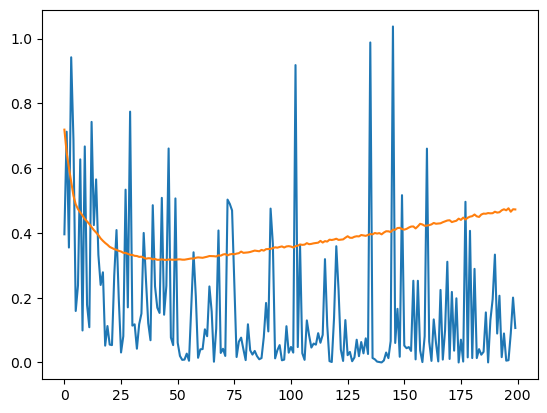

In [129]:
plt.plot(loss_train)
plt.plot(loss_validation)

### 200-64-16-4

In [18]:
class SLDNN(nn.Module):
    def __init__(self):
        super(SLDNN, self).__init__()
        self.fc1 = nn.Linear(200, 64)
        self.fc2 = nn.Linear(64, 16)
#         self.fc3 = nn.Linear(64, 16)
        self.output = nn.Linear(16, 4)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
#         x = self.act(self.fc3(x))
        
        # CrossEntropyLoss apply softmax automatically
        return self.output(x)
    
#         x = self.sig(self.fc3(x))
#         return x

In [131]:
classifier = SLDNN().cuda()

print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.CrossEntropyLoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x.cuda()
        tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x.cuda()
            tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_valid)))
    print(time.time() - t0)

#     print(time.time() - t0)
torch.save(classifier.cuda(), "../data/SupLearn/Classifier.pt")
np.savetxt("../data/SupLearn/lossClassifierTraining.dat", [loss_train, loss_validation])

13972
Epoch: 0001, Training loss=1.456019, Validation loss=0.786205, valid accuracy=0.644721
18.16793918609619
Epoch: 0002, Training loss=0.650406, Validation loss=0.697365, valid accuracy=0.692591
21.656566619873047
Epoch: 0003, Training loss=0.233004, Validation loss=0.660391, valid accuracy=0.713590
20.478137016296387
Epoch: 0004, Training loss=0.493061, Validation loss=0.630474, valid accuracy=0.730622
22.07361149787903
Epoch: 0005, Training loss=0.812376, Validation loss=0.604382, valid accuracy=0.745363
20.356573343276978
Epoch: 0006, Training loss=0.136681, Validation loss=0.580074, valid accuracy=0.756556
20.248222827911377
Epoch: 0007, Training loss=1.263927, Validation loss=0.559727, valid accuracy=0.765620
20.941830158233643
Epoch: 0008, Training loss=0.834122, Validation loss=0.543950, valid accuracy=0.772265
22.41158962249756
Epoch: 0009, Training loss=0.511720, Validation loss=0.530675, valid accuracy=0.778265
20.44349694252014
Epoch: 0010, Training loss=0.186668, Validat

Epoch: 0079, Training loss=0.224497, Validation loss=0.363728, valid accuracy=0.863746
16.10002040863037
Epoch: 0080, Training loss=0.065723, Validation loss=0.362693, valid accuracy=0.864037
16.760319709777832
Epoch: 0081, Training loss=0.448424, Validation loss=0.364208, valid accuracy=0.863972
17.106816053390503
Epoch: 0082, Training loss=0.097563, Validation loss=0.362436, valid accuracy=0.863392
16.867675304412842
Epoch: 0083, Training loss=0.445731, Validation loss=0.362827, valid accuracy=0.864972
16.865190267562866
Epoch: 0084, Training loss=0.184864, Validation loss=0.362599, valid accuracy=0.864069
16.08500361442566
Epoch: 0085, Training loss=0.582457, Validation loss=0.362102, valid accuracy=0.864875
15.913988828659058
Epoch: 0086, Training loss=0.880240, Validation loss=0.361130, valid accuracy=0.864617
16.31640362739563
Epoch: 0087, Training loss=0.145845, Validation loss=0.361404, valid accuracy=0.865101
15.919841051101685
Epoch: 0088, Training loss=0.423221, Validation l

Epoch: 0157, Training loss=0.164304, Validation loss=0.352104, valid accuracy=0.870424
15.954104661941528
Epoch: 0158, Training loss=0.248748, Validation loss=0.351763, valid accuracy=0.871069
16.44610047340393
Epoch: 0159, Training loss=0.100241, Validation loss=0.351892, valid accuracy=0.871520
15.574841976165771
Epoch: 0160, Training loss=0.281585, Validation loss=0.352343, valid accuracy=0.870230
15.799652338027954
Epoch: 0161, Training loss=0.142405, Validation loss=0.351529, valid accuracy=0.871230
18.43275260925293
Epoch: 0162, Training loss=0.196535, Validation loss=0.352548, valid accuracy=0.870972
17.736987590789795
Epoch: 0163, Training loss=0.114269, Validation loss=0.351590, valid accuracy=0.871133
16.51880145072937
Epoch: 0164, Training loss=0.040650, Validation loss=0.351520, valid accuracy=0.870036
15.887745141983032
Epoch: 0165, Training loss=0.285730, Validation loss=0.352213, valid accuracy=0.869456
16.29120397567749
Epoch: 0166, Training loss=0.505116, Validation lo

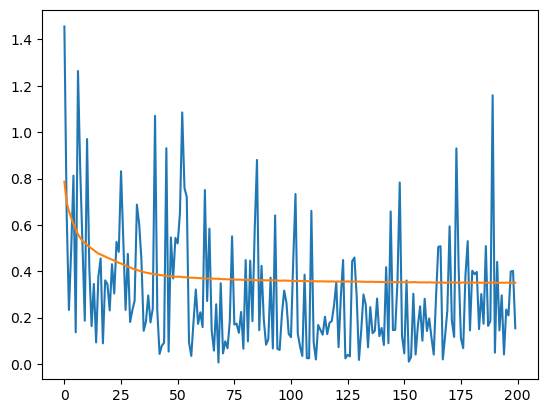

In [132]:
plt.plot(loss_train)
plt.plot(loss_validation)

In [133]:
classifier.cpu()

SLDNN(
  (fc1): Linear(in_features=200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=4, bias=True)
  (act): ReLU()
)

In [137]:
X_train.shape

(216998, 200)

In [23]:
classifier = torch.load('../Model_cached/Classifier_64-16.pt').cpu()

In [24]:
outputTest = classifier(torch.FloatTensor(X_test))

In [25]:
resTest = torch.argmax(nn.Softmax(dim=1)(outputTest), dim=1)

In [26]:
resTest

tensor([1, 1, 1,  ..., 0, 1, 0])

In [27]:
target_test

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [28]:
print(torch.eq(torch.tensor(target_test), resTest).sum().item())
print(torch.eq(torch.tensor(target_test), resTest).sum().item() / len(target_test))

64311
0.8928859023130536


In [29]:
print(len(target_test) - torch.eq(torch.tensor(target_test>1), resTest<=1).sum().item())
print(1 - torch.eq(torch.tensor(target_test>1), resTest<=1).sum().item() / len(target_test))

65829
0.9139616249687613


#### BBH accuracy

#### SG accuracy

#### Noise accuracy

### 200-64-64-16-4

In [169]:
class SLDNN(nn.Module):
    def __init__(self):
        super(SLDNN, self).__init__()
        self.fc1 = nn.Linear(200, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 16)
        self.output = nn.Linear(16, 4)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        
        # CrossEntropyLoss apply softmax automatically
        return self.output(x)
    
#         x = self.sig(self.fc3(x))
#         return x

In [171]:
classifier = SLDNN().cuda()

print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.CrossEntropyLoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x.cuda()
        tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x.cuda()
            tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_valid)))
    print(time.time() - t0)

#     print(time.time() - t0)
torch.save(classifier.cuda(), "../data/SupLearn/Classifier_64-64-16.pt")
np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

18132
Epoch: 0001, Training loss=0.474716, Validation loss=0.742357, valid accuracy=0.666301
19.324056386947632
Epoch: 0002, Training loss=0.374694, Validation loss=0.680511, valid accuracy=0.710719
18.770312786102295
Epoch: 0003, Training loss=0.670147, Validation loss=0.638941, valid accuracy=0.732686
26.299160957336426
Epoch: 0004, Training loss=1.250036, Validation loss=0.613479, valid accuracy=0.747782
25.375213623046875
Epoch: 0005, Training loss=0.738831, Validation loss=0.598099, valid accuracy=0.755072
24.368035554885864
Epoch: 0006, Training loss=0.144531, Validation loss=0.584319, valid accuracy=0.763653
26.16805338859558
Epoch: 0007, Training loss=0.956067, Validation loss=0.573101, valid accuracy=0.768459
22.840923309326172
Epoch: 0008, Training loss=0.247889, Validation loss=0.559672, valid accuracy=0.771911
17.952731370925903
Epoch: 0009, Training loss=0.985831, Validation loss=0.545236, valid accuracy=0.777846
19.1991286277771
Epoch: 0010, Training loss=0.119106, Valida

Epoch: 0079, Training loss=0.413522, Validation loss=0.343796, valid accuracy=0.872682
22.00032067298889
Epoch: 0080, Training loss=0.232846, Validation loss=0.341762, valid accuracy=0.872649
21.60247564315796
Epoch: 0081, Training loss=0.185144, Validation loss=0.341279, valid accuracy=0.871746
20.81746816635132
Epoch: 0082, Training loss=0.694943, Validation loss=0.340446, valid accuracy=0.873165
15.635480403900146
Epoch: 0083, Training loss=0.013741, Validation loss=0.339733, valid accuracy=0.873811
18.37843155860901
Epoch: 0084, Training loss=0.176204, Validation loss=0.340330, valid accuracy=0.873552
18.112579584121704
Epoch: 0085, Training loss=0.044700, Validation loss=0.338964, valid accuracy=0.874036
18.610584497451782
Epoch: 0086, Training loss=0.085692, Validation loss=0.338031, valid accuracy=0.873004
17.6256582736969
Epoch: 0087, Training loss=1.271693, Validation loss=0.336898, valid accuracy=0.874456
17.54631781578064
Epoch: 0088, Training loss=0.262004, Validation loss=

Epoch: 0157, Training loss=0.030162, Validation loss=0.323473, valid accuracy=0.883068
16.576465368270874
Epoch: 0158, Training loss=0.017756, Validation loss=0.323684, valid accuracy=0.882520
17.201162338256836
Epoch: 0159, Training loss=0.049744, Validation loss=0.322051, valid accuracy=0.882294
16.998027324676514
Epoch: 0160, Training loss=0.020710, Validation loss=0.324497, valid accuracy=0.882488
18.030097723007202
Epoch: 0161, Training loss=0.132886, Validation loss=0.323545, valid accuracy=0.883584
17.672110080718994
Epoch: 0162, Training loss=0.104540, Validation loss=0.323433, valid accuracy=0.882488
18.239886045455933
Epoch: 0163, Training loss=0.748655, Validation loss=0.322065, valid accuracy=0.883455
22.136264085769653
Epoch: 0164, Training loss=0.167221, Validation loss=0.323359, valid accuracy=0.883875
22.291666269302368
Epoch: 0165, Training loss=0.276267, Validation loss=0.322165, valid accuracy=0.883036
21.337865114212036
Epoch: 0166, Training loss=0.061257, Validatio

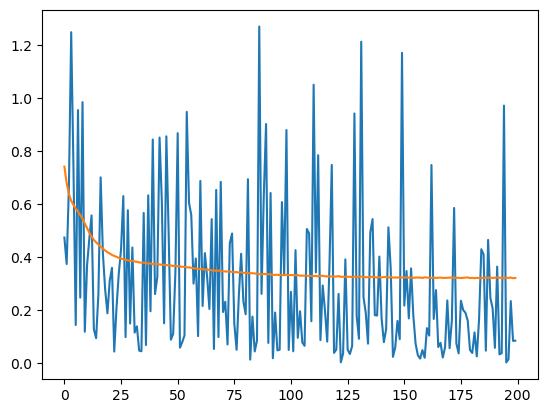

In [172]:
plt.plot(loss_train)
plt.plot(loss_validation)

In [173]:
classifier.eval()
classifier.cpu()

SLDNN(
  (fc1): Linear(in_features=200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=4, bias=True)
  (act): ReLU()
)

In [174]:
outputTest = nn.Softmax(dim=1)(classifier(torch.FloatTensor(X_test)))

In [175]:
resTest = torch.argmax(outputTest, dim=1)

In [178]:
print(torch.eq(torch.tensor(target_test), resTest).sum().item())
print(torch.eq(torch.tensor(target_test), resTest).sum().item() / len(target_test))

54902
0.8855304117808351


In [179]:
print(len(target_test) - torch.eq(torch.tensor(target_test>1), resTest<=1).sum().item())
print(1 - torch.eq(torch.tensor(target_test>1), resTest<=1).sum().item() / len(target_test))

55661
0.8977725447184632


In [184]:
foo = outputTest.detach().numpy()

In [202]:
def calcROCPoint(index, threshold):
    nTotalSignal = np.sum(target_test==index)
    nTotalBKG = len(target_test) - nTotalSignal;
    
    nTP = np.sum(np.logical_and(target_test==index, foo[:, index]>threshold));
#     nFN = nTotalSignal - nTP;
    nFP = np.sum(np.logical_and(target_test!=index, foo[:, index]>threshold));
#     nTN = nTotalBKG - nFP;
    
    return [nFP/nTotalBKG, nTP/nTotalSignal]

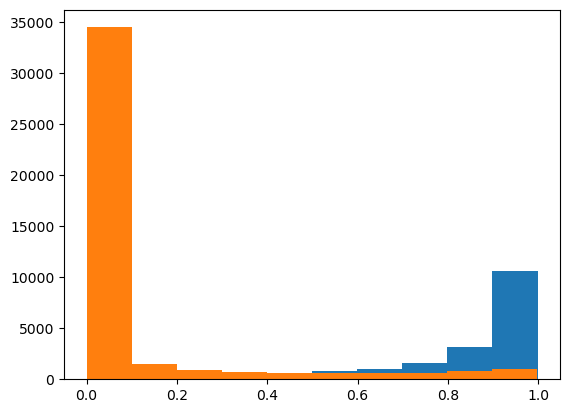

In [200]:
bar = plt.hist(foo[target_test==1, 1])
bar = plt.hist(foo[target_test!=1, 1])

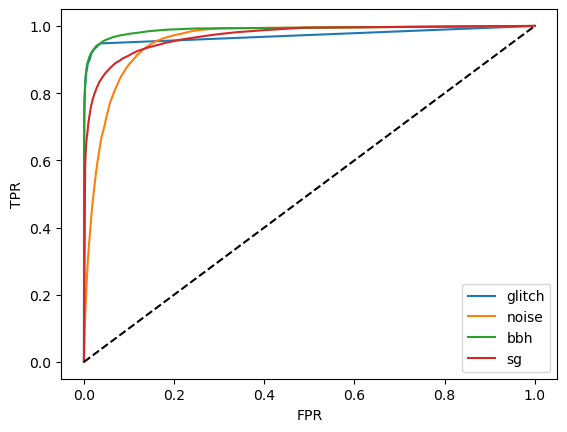

In [216]:
sig_type = ["glitch", "noise", "bbh", "sg"]
for ind in range(4):
    bar = np.array([calcROCPoint(ind, 1-0.01*i) for i in range(101)])
    plt.plot(bar[:, 0], bar[:, 1], label=sig_type[ind])
    
plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.savefig("../results/SupLearnROC_64-64-16.jpg")

### 200-64-16-3

In [22]:
class SLDNN(nn.Module):
    def __init__(self):
        super(SLDNN, self).__init__()
        self.fc1 = nn.Linear(200, 32)
        self.fc2 = nn.Linear(32, 8)
#         self.fc3 = nn.Linear(64, 16)
        self.output = nn.Linear(8, 3)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
#         x = self.act(self.fc3(x))
        
        # CrossEntropyLoss apply softmax automatically
        return self.output(x)
    
#         x = self.sig(self.fc3(x))
#         return x

In [ ]:
def custom_cross_entropy_loss(input, target):
    """
    自定义的交叉熵损失函数
    
    参数:
    input (torch.Tensor): 模型输出的logits,shape为 (batch_size, num_classes)
    target (torch.Tensor): 真实标签,shape为 (batch_size,)
    """
    batch_size = input.size(0)
    
    # 使用 sigmoid 计算概率
    prob = torch.sigmoid(input)
    
    # 计算 log(1-p) 部分
    loss_pos = -torch.log(prob.gather(1, target.unsqueeze(1))).squeeze(1)
    loss_neg = -torch.log(1 - prob).gather(1, target.unsqueeze(1)).squeeze(1)
    
    # 计算平均损失
    loss = (loss_pos + loss_neg) / batch_size
    
    return loss.mean()

In [ ]:
custom_cross_entropy_loss(torch.FloatTensor((1,0,0)),torch.FloatTensor((0.5,0.2,0.3)))

In [23]:
classifier = SLDNN().cuda()

print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.CrossEntropyLoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x.cuda()
        tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x.cuda()
            tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_valid)))
    print(time.time() - t0)

#     print(time.time() - t0)


6723
Epoch: 0001, Training loss=0.627491, Validation loss=0.598912, valid accuracy=0.797878
6.176495552062988
Epoch: 0002, Training loss=0.488855, Validation loss=0.409021, valid accuracy=0.849466
6.010619401931763
Epoch: 0003, Training loss=0.336172, Validation loss=0.360358, valid accuracy=0.864342
6.120069742202759
Epoch: 0004, Training loss=0.099298, Validation loss=0.322968, valid accuracy=0.878681
5.99014139175415
Epoch: 0005, Training loss=0.122617, Validation loss=0.289221, valid accuracy=0.890905
6.118699789047241
Epoch: 0006, Training loss=0.243932, Validation loss=0.262626, valid accuracy=0.902437
6.107273817062378
Epoch: 0007, Training loss=0.165651, Validation loss=0.245055, valid accuracy=0.909779
5.997369766235352
Epoch: 0008, Training loss=0.107581, Validation loss=0.233707, valid accuracy=0.914584
6.090300559997559
Epoch: 0009, Training loss=0.382453, Validation loss=0.226533, valid accuracy=0.916737
6.116962194442749
Epoch: 0010, Training loss=0.302836, Validation los

In [25]:
torch.save(classifier.cuda(), "../Data_cached/SupLearn/Classifier_reduced.pt")
np.savetxt("../Data_cached/SupLearn/lossClassifierTraining_reduced.dat", [loss_train, loss_validation])

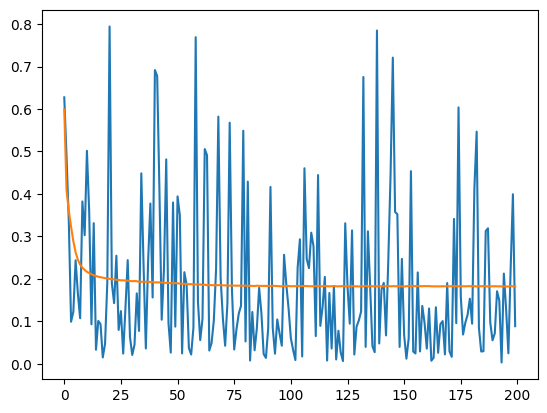

In [24]:
plt.plot(loss_train)
plt.plot(loss_validation)

In [27]:
classifier.cpu()

SLDNN(
  (fc1): Linear(in_features=200, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
  (act): ReLU()
)

In [26]:
X_train.shape

(182092, 200)

In [28]:
X_test.shape

(72026, 200)

In [29]:
3 * nTest

60000

In [30]:
nTest_g

12026

In [ ]:
testData = torch.FloatTensor(X_test)

In [94]:
nn.Softmax()(classifier(testData[1]))

C:\Users\Liyang Miao\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([3.9118e-05, 9.9958e-01, 3.7686e-04], grad_fn=<SoftmaxBackward0>)

In [32]:
# X_test[:nTest] = realbkg_trimmed[permBKG[-nTest:]]
# X_test[nTest:2*nTest] = realbbh_trimmed[permBBH[-nTest:]]
# X_test[2*nTest:3*nTest] = realsg_trimmed[permSG[-nTest:]]
# X_test[3*nTest:] = realglitch_trimmed[permGLITCH[-nTest_g:]]

# target_test[:nTest] = 1;
# target_test[nTest:2*nTest] = 2;
# target_test[2*nTest:3*nTest] = 3;


resTest = nn.Sigmoid()(classifier(torch.FloatTensor(X_test)))

In [45]:
resTest = torch.argmax(nn.Softmax(dim=1)(outputTest), dim=1)

In [46]:
resTest[1]

tensor(1)

In [99]:
Sigmoid_cut = np.arange(0,1,0.1)
Sigmoid_cut

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [102]:
import itertools

Sigmoid_cut = list(itertools.product(Sigmoid_cut, Sigmoid_cut, Sigmoid_cut))

In [103]:
Sigmoid_cut

[(0.0, 0.0, 0.0),
 (0.0, 0.0, 0.1),
 (0.0, 0.0, 0.2),
 (0.0, 0.0, 0.30000000000000004),
 (0.0, 0.0, 0.4),
 (0.0, 0.0, 0.5),
 (0.0, 0.0, 0.6000000000000001),
 (0.0, 0.0, 0.7000000000000001),
 (0.0, 0.0, 0.8),
 (0.0, 0.0, 0.9),
 (0.0, 0.1, 0.0),
 (0.0, 0.1, 0.1),
 (0.0, 0.1, 0.2),
 (0.0, 0.1, 0.30000000000000004),
 (0.0, 0.1, 0.4),
 (0.0, 0.1, 0.5),
 (0.0, 0.1, 0.6000000000000001),
 (0.0, 0.1, 0.7000000000000001),
 (0.0, 0.1, 0.8),
 (0.0, 0.1, 0.9),
 (0.0, 0.2, 0.0),
 (0.0, 0.2, 0.1),
 (0.0, 0.2, 0.2),
 (0.0, 0.2, 0.30000000000000004),
 (0.0, 0.2, 0.4),
 (0.0, 0.2, 0.5),
 (0.0, 0.2, 0.6000000000000001),
 (0.0, 0.2, 0.7000000000000001),
 (0.0, 0.2, 0.8),
 (0.0, 0.2, 0.9),
 (0.0, 0.30000000000000004, 0.0),
 (0.0, 0.30000000000000004, 0.1),
 (0.0, 0.30000000000000004, 0.2),
 (0.0, 0.30000000000000004, 0.30000000000000004),
 (0.0, 0.30000000000000004, 0.4),
 (0.0, 0.30000000000000004, 0.5),
 (0.0, 0.30000000000000004, 0.6000000000000001),
 (0.0, 0.30000000000000004, 0.7000000000000001),
 (0.

In [47]:
target_test

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [51]:
nn.Sigmoid()(classifier(testData[0])) < Sigmoid_cut[0]

tensor([False, False, False])

In [54]:
np.all(nn.Sigmoid()(classifier(testData[0])).detach().numpy() < Sigmoid_cut[0])

False

In [104]:
accuracy = np.zeros((len(Sigmoid_cut), 4))

for i in range(len(Sigmoid_cut)):
    
    resTest = torch.argmax(nn.Softmax(dim=1)(outputTest), dim=1)

    for j in range(len(X_test)):
        if np.all(nn.Softmax()(classifier(testData[j])).detach().numpy() < Sigmoid_cut[i]):
            resTest[j] = 3
            # print(j)
    
    accuracy_glitch = (resTest[3*nTest:].detach().numpy() == 0).sum() / nTest_g
    accuracy_noise = (resTest[:nTest].detach().numpy() == 1).sum() / nTest
    accuracy_bbh = (resTest[nTest:2*nTest].detach().numpy() == 2).sum() / nTest
    accuracy_sg = (resTest[2*nTest:3*nTest].detach().numpy() == 3).sum() / nTest

    accuracy[i] = np.array([accuracy_glitch, accuracy_noise, accuracy_bbh, accuracy_sg])

C:\Users\Liyang Miao\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


KeyboardInterrupt: 

In [63]:
(resTest[3*nTest:].detach().numpy() == 0).sum() / nTest_g

0.952186928321969

In [73]:
np.all(np.array([0.25742987, 0.803871  , 0.42266008]) < 0.9)

True

In [87]:
np.all(nn.Sigmoid()(classifier(testData[2*nTest:3*nTest])).detach().numpy() < 0.9 * np.ones(3), axis = 1).sum()

2006

In [96]:
accuracy

array([[0.91518377, 0.75165   , 0.83165   , 0.15915   ],
       [0.91293863, 0.7328    , 0.82635   , 0.1711    ],
       [0.91094296, 0.7137    , 0.8207    , 0.18535   ],
       [0.90811575, 0.6923    , 0.8138    , 0.2033    ],
       [0.90470647, 0.6652    , 0.80625   , 0.22575   ],
       [0.89955097, 0.63015   , 0.7966    , 0.2544    ],
       [0.89497755, 0.58715   , 0.78325   , 0.2916    ],
       [0.88865791, 0.52715   , 0.7663    , 0.343     ],
       [0.87909529, 0.43935   , 0.74      , 0.41865   ],
       [0.86146682, 0.2937    , 0.69595   , 0.5512    ]])

In [93]:
accuracy

array([[0.93364377, 0.80595   , 0.87785   , 0.1003    ],
       [0.93156494, 0.78275   , 0.87015   , 0.1181    ],
       [0.92848828, 0.75455   , 0.86195   , 0.1422    ],
       [0.92599368, 0.71635   , 0.85165   , 0.1713    ],
       [0.92183602, 0.67285   , 0.8399    , 0.20935   ],
       [0.91709629, 0.61275   , 0.82245   , 0.25645   ],
       [0.91036088, 0.53455   , 0.80265   , 0.3227    ],
       [0.90279395, 0.4337    , 0.77475   , 0.41465   ],
       [0.88990521, 0.2924    , 0.73015   , 0.5507    ],
       [0.86778646, 0.1128    , 0.6494    , 0.76505   ]])

In [90]:
accuracy

array([[9.52186928e-01, 9.38000000e-01, 9.16000000e-01, 0.00000000e+00],
       [9.52186928e-01, 9.38000000e-01, 9.16000000e-01, 0.00000000e+00],
       [9.52186928e-01, 9.38000000e-01, 9.16000000e-01, 0.00000000e+00],
       [9.52186928e-01, 9.38000000e-01, 9.16000000e-01, 0.00000000e+00],
       [9.52186928e-01, 9.38000000e-01, 9.16000000e-01, 0.00000000e+00],
       [9.52186928e-01, 9.38000000e-01, 9.16000000e-01, 0.00000000e+00],
       [9.52186928e-01, 9.37750000e-01, 9.15950000e-01, 3.00000000e-04],
       [9.51105937e-01, 9.34450000e-01, 9.13950000e-01, 3.55000000e-03],
       [9.47280891e-01, 9.12850000e-01, 9.07050000e-01, 2.13000000e-02],
       [9.33643772e-01, 8.05950000e-01, 8.77850000e-01, 1.00300000e-01]])

In [35]:
outputTest = classifier(torch.FloatTensor(X_test))

In [ ]:
resTest = torch.argmax(nn.Softmax(dim=1)(outputTest), dim=1)

In [ ]:
resTest

tensor([1, 1, 1,  ..., 3, 1, 0])

In [ ]:
target_test

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [ ]:
print(torch.eq(torch.tensor(target_test), resTest).sum().item())
print(torch.eq(torch.tensor(target_test), resTest).sum().item() / len(target_test))

54037
0.8715785738479653


In [ ]:
print(len(target_test) - torch.eq(torch.tensor(target_test>1), resTest<=1).sum().item())
print(1 - torch.eq(torch.tensor(target_test>1), resTest<=1).sum().item() / len(target_test))

55029
0.8875788319166438
